In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Exercise 1: 

## Question 2:

In [140]:
def F(x, X, p):
    """ Cumulative Distribution Function F
    Parameters:
        X (list): list
        x (float): value
        p (list): probas
    Returns:
        k (int): as defined in the algorithm
    """
    n = len(X)
    proba = 0.0
    for k in range(n):
        if X[k] <= x:
            proba += p[k]
        else:
            break
    return proba


def algorithm1(X, p, cdf, n_sample):
    """ Algorithm 1 
    Parameters:
        X (list): list 
        p (list): probas
        n_sample (int): number of samples
    Returns:
        k (list): as defned in the algorithm
    """
    U = np.random.uniform(0, 1, n_sample)
    list_k = []
    for u in U:
        cumulative_sum = 0
        for idx, prob in enumerate(p):
            cumulative_sum += prob
            if cumulative_sum >= u:
                list_k.append(X[idx])
                break
    return list_k

n = 10 ** 4    # Dimension of the space
prob_vector = np.random.rand(n) / n
X = np.random.randint(0, 10 ** 5,
                      size = n)
X = np.sort(X)
X_simul = algorithm1(X, prob_vector, F, 100)
print("Random simulations from X:", np.random.choice(X_simul, 10, replace=False))

Random simulations from X: [91828 27532 84101 15973 39106 14721 52970 51677 93106  3782]


## Question 3:

We test our implementation on $(X_i)_{i \in \left[ 1,n \right]}$ from a $\mathcal{G} (p) $ distribution. 

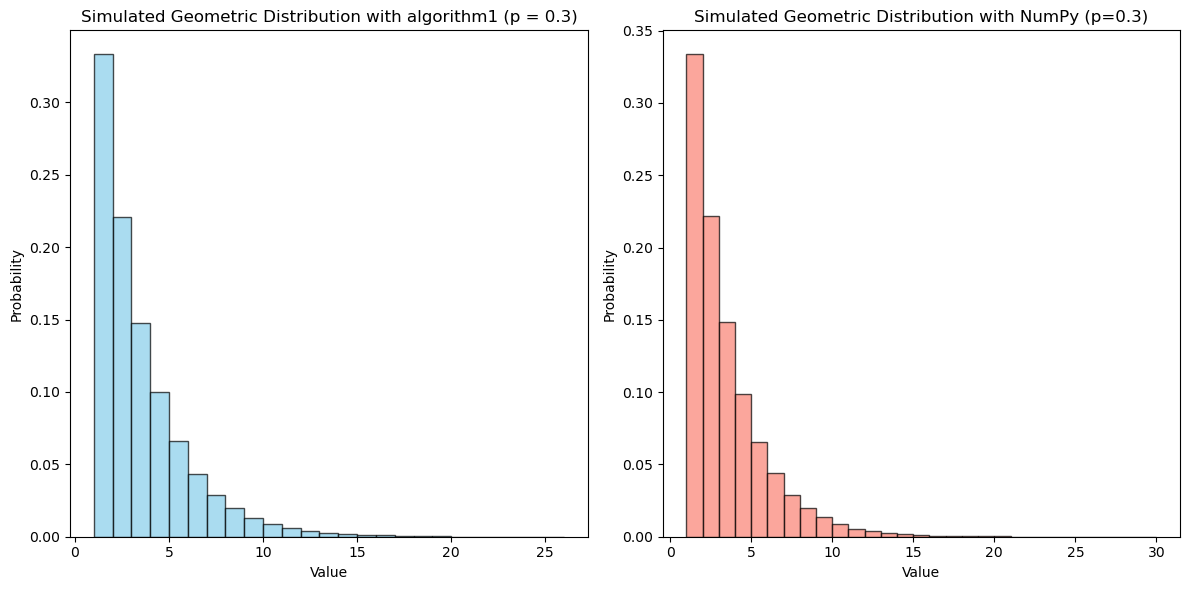

In [141]:
import scipy.stats as stats

p = 1 / 3
X = np.arange(1, 1000)
n_samples = 500_000
prob_vector = (1 - p) ** (X - 1) * p
prob_vector /= prob_vector.sum()

n_samples = 10 ** 5
samples_custom = algorithm1(X, prob_vector, F, n_samples)
samples_numpy = np.random.geometric(p, n_samples)

# Plot the histogram of both samples for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(samples_custom, bins = range(1, max(samples_custom) + 1), density = True, alpha=0.7, color = 'skyblue', edgecolor = 'black')
plt.title("Simulated Geometric Distribution with algorithm1 (p = 0.3)")
plt.xlabel("Value")
plt.ylabel("Probability")

plt.subplot(1, 2, 2)
plt.hist(samples_numpy, bins = range(1, max(samples_numpy) + 1), density = True, alpha = 0.7, color='salmon', edgecolor = 'black')
plt.title("Simulated Geometric Distribution with NumPy (p=0.3)")
plt.xlabel("Value")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# Exercise 2:

## Question 2:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


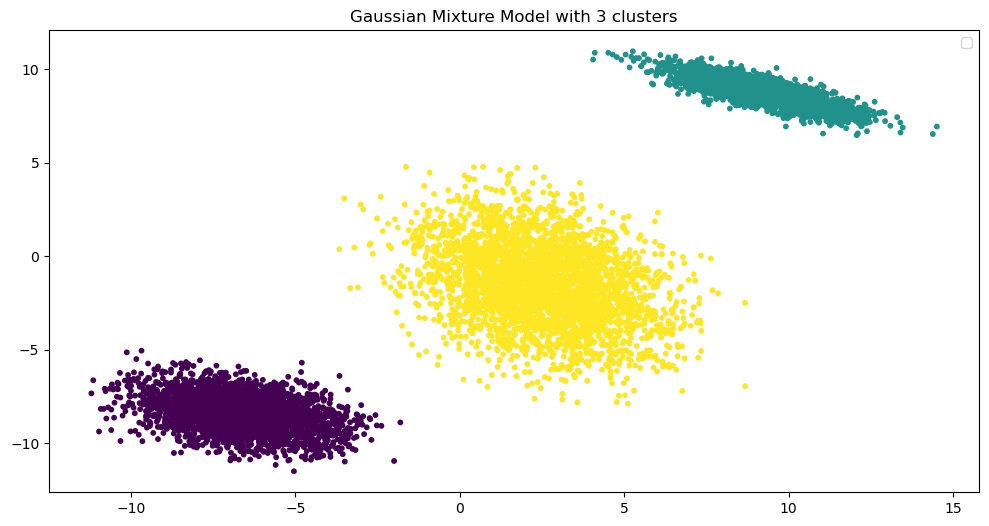

In [142]:
np.random.seed(2001)
def sample_gaussian_mixture(alpha, mu, sigma, n_samples):
    """ Sample from a Gaussian mixture distribution
    Parameters:
    ----------
    alpha (list): list of weights of the Gaussian components
    mu (list): list of means of the Gaussian components
    sigma (list): list of standard deviations of the Gaussian components
    n_samples (int): number of samples to draw
    
    Returns:
    --------
    X (list): sample from the Gaussian mixture distribution
    z (list): class of each sample
    """
    z = algorithm1(np.arange(len(alpha)), alpha, F, n_samples)
    means = mu[z]
    covs = sigma[z]
    sample_gaussian_mixture = np.array([np.random.multivariate_normal(mean, cov, 1) for mean, cov in zip(means, covs)]).reshape(n_samples, -1)
    return sample_gaussian_mixture, z

def generate_invertible_matrices(n_clusters, d):
    """ Generate n_clusters invertible matrices of size (n_dim, n_dim) """
    matrix = []
    while len(matrix) < n_clusters:
        A = np.random.randn(d, d)  # Matrice aléatoire
        sdp_matrix = np.dot(A.T, A) + np.eye(d) * 1e-1  
        matrix.append(sdp_matrix)
    return np.array(matrix)

n_samples = 10 ** 4
n_clusters = 3
n_dim = 2
# Initialize the parameters of the Gaussian mixture (alpha (uniform distribution), mu, sigma)
alpha, mu, sigma = np.array(n_clusters * [1 / n_clusters]), np.random.uniform(-10, 10, size = (n_clusters, n_dim)), generate_invertible_matrices(n_clusters, n_dim)
X, z = sample_gaussian_mixture(alpha, mu, sigma, n_samples)

plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c = z, cmap = 'viridis', s = 10)
plt.title("Gaussian Mixture Model with 3 clusters")
plt.legend()
plt.show()

## Question 3: 

The Expectation-Maximization (EM) algorithm is an iterative method for finding a local maximum of the likelihood. This technique applies to any mixture model (in fact, any model with latent variables).

Given the latent variables, the log-likelihood becomes (we keep the notations of the exercise):

$ l(\theta ; z) = \log p_{\theta} (x, z) =  \displaystyle \sum _{i=1} ^m \alpha _i + \displaystyle \sum _{i=1} ^m \frac{d \mathbb{P} _{X | \theta, Z = i}}{d \lambda} (x)$ 

so that each set of parameters $(\mu _1, \sigma _1),...,( \mu _m, \sigma _m)$ can be estimated separately using the corresponding samples.

In [143]:
def log_gaussian_pdf(x_i, mu_j, sigma_j):
    """
    Computes log N(x_i | mu_j, sigma_j)
    """
    d = len(mu_j)
    if np.linalg.det(sigma_j) == 0:
        return -np.inf
    else:
        return -0.5 * (d * np.log(2 * np.pi) + np.log(np.linalg.det(sigma_j)) + (x_i - mu_j).T @ np.linalg.inv(sigma_j) @ (x_i - mu_j))

def plot_countour(X, x, y, z, ax, xlim, ylim):
    def fixed_aspect_ratio(ratio, ax):
        '''
        Set a fixed aspect ratio on matplotlib plots 
        regardless of axis units
        '''
        xvals, yvals = ax.get_xlim(), ax.get_ylim()

        xrange = xvals[1] - xvals[0]
        yrange = yvals[1] - yvals[0]
        ax.set_aspect(ratio* (xrange / yrange), adjustable='box')
        
    # contour the gridded data, plotting dots at the randomly spaced data points.
    ax.contour(x, y, z, 6, linewidths=0.5, colors='k')
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    fixed_aspect_ratio(1, ax)
    return ax

In [149]:
class EM_GMM():
    def __init__(self, X, n_clusters):
        self.n_clusters = n_clusters
        self.X = X
        self.N = X.shape[0]   # Number of samples
        self.d = X.shape[1]   # Dimension of the space

    def _initialize_parameters(self):   
        d = self.d
        self.alpha = np.ones(self.n_clusters) / self.n_clusters
        self.mu = np.random.uniform(-10, 10, n_clusters * d).reshape(n_clusters, d)
        self.sigma = generate_invertible_matrices(self.n_clusters, self.X.shape[1])
        self.sigma = np.array([np.identity(d) for _ in range(n_clusters)])
        self.BETA = np.zeros((self.N, self.n_clusters))    # Posterior probabilities

        self.best_alpha = None
        self.best_mu = None
        self.best_sigma = None
        self.best_elbo = -np.inf

        self.evolution_likelihood = []

    @staticmethod
    def log_gaussian_pdf(x_i, mu_j, sigma_j):
        """
        Computes log N(x_i | mu_j, sigma_j)
        """
        d = len(mu_j)
        if np.linalg.det(sigma_j) == 0:
            return -np.inf
        else:
            return -0.5 * (d * np.log(2 * np.pi) + np.log(np.linalg.det(sigma_j)) + (x_i - mu_j).T @ np.linalg.inv(sigma_j) @ (x_i - mu_j))


    def likelihood(self):
        N = self.N 
        n_clusters = self.n_clusters
        d = self.d 
        E1 = 0.
        E2 = 0.
        for i in range(N):
            x_i = self.X[i]
            for cluster in range(n_clusters):
                alpha_j = self.alpha[cluster] 
                BETAij = self.BETA[i, cluster]
                mu_j = self.mu[cluster, :]
                sigma_j = self.sigma[cluster, :, :]

                log_alpha = np.log(alpha_j)
                log_normal_dist = log_gaussian_pdf(x_i, mu_j, sigma_j)
                prob = BETAij * (log_alpha + log_normal_dist)
                E1 += prob
                #E2 += BETAij * np.log(BETAij)    # Entropy term
        loss = E1 #- E2
        return loss
    

    def fit(self, max_iter = 100, rtol = 1e-3, verbose = False):
        self._initialize_parameters()
        prev_vlb = -np.inf
        for _iter in range(max_iter):
            try:
                # Perform the Expectation (E) step to calculate the responsibilities
                self._E_step()             
                self._M_step()               
                vlb = self.likelihood()
                self.evolution_likelihood.append(vlb)
                # If `verbose` is True, print the current iteration and lower bound value
                if verbose:
                    print('{}. Lower bound: {}'.format(_iter + 1, vlb))

                # Check convergence: if the relative change in VLB is below the tolerance or if `vlb` is NaN, exit loop
                """ 
                if np.abs((vlb - prev_vlb) / prev_vlb) <= rtol or np.isnan(vlb):
                    break
                prev_vlb = vlb
                """
                
                # Store the best parameters if the current VLB is higher than the best found so far
                if vlb > self.best_elbo:
                    self.best_elbo = vlb
                    self.best_mu = self.mu
                    self.best_alpha = self.alpha
                    self.best_sigma = self.sigma
            
            # Catch any linear algebra errors (like singular matrices), which can occur during optimization
            except np.linalg.LinAlgError:
                print("Singular matrix: components collapsed")
                pass

    def _E_step(self):
        TEMP_BETA = np.zeros((self.N, self.n_clusters))
        for i in range(self.N):
            x_i = self.X[i, :]
            denominator = []
            for cluster in range(self.n_clusters):
                alpha_j = self.alpha[cluster]
                mu_j = self.mu[cluster, :]
                sigma_j = self.sigma[cluster, :, :]
                denominator.append(alpha_j * stats.multivariate_normal.pdf(x_i, mu_j, sigma_j)) 
                
                log_alpha = np.log(alpha_j)
                log_normal_dist = log_gaussian_pdf(x_i, mu_j, sigma_j)
                log_num = log_alpha + log_normal_dist
                TEMP_BETA[i, cluster] = log_num


            TEMP_BETA[i, :] = np.exp(TEMP_BETA[i, :] - np.log(np.sum(denominator)))
        self.BETA = TEMP_BETA
    
    def _M_step(self):
        d, n_clusters, N = self.d, self.n_clusters, self.N
        X, mu = self.X, self.mu
        denoms = np.sum(self.BETA, axis = 0)

        self.alpha = denoms / N     # Update alpha

        # update mu 
        numerator_mu = [np.dot(self.BETA[:, cluster], X) for cluster in range(n_clusters)]   # (n_clusters, d)
        for ix, (num, den) in enumerate(zip(numerator_mu, denoms)):
            self.mu[ix, :] = num / den

        # update sigma
        numerator_sigma = [np.dot(self.BETA[:, cluster] * (X - self.mu[cluster]).T, X - self.mu[cluster]) for cluster in range(n_clusters)]
        for ix, (num, den) in enumerate(zip(numerator_sigma, denoms)):
            self.sigma[ix, :, :] = num / den
        

    def plot_clusters(self):
        n_clusters = self.n_clusters

        xmin, xmax = (-12, 12)
        ymin, ymax = (-12, 12)

        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10, 10)

        for c in range(n_clusters):
            rv = stats.multivariate_normal(self.mu[c], self.sigma[c])

            x = np.linspace(xmin, xmax, 500)
            y = np.linspace(ymin, ymax, 500)

            X1, Y1 = np.meshgrid(x, y)
            xy = np.column_stack([X1.flat, Y1.flat])

            # density values at the grid points
            Z = rv.pdf(xy).reshape(X1.shape)
            ax = plot_countour(X, X1, Y1, Z, ax = ax, xlim = (xmin, xmax), ylim = (ymin, ymax))
            ax.plot(self.mu[c, 0], self.mu[c, 1], 'ro')
            
        # plot data points
        labels = self.BETA.argmax(1)
        ax.scatter(X[:, 0], X[:, 1], c = labels, s = 30)        
        plt.show()


1. Lower bound: -55286.17404416125
2. Lower bound: -53286.414365153614
3. Lower bound: -48476.92658226471
4. Lower bound: -48397.44430481819
5. Lower bound: -48359.42017769519
6. Lower bound: -48320.30555701711
7. Lower bound: -48277.06345785446
8. Lower bound: -48228.867160800975
9. Lower bound: -48171.73254743608
10. Lower bound: -48094.13401093847
11. Lower bound: -47980.847650906355
12. Lower bound: -47819.64330698873
13. Lower bound: -47597.13100708398
14. Lower bound: -47288.94127598462
15. Lower bound: -46844.40187195725
16. Lower bound: -46127.14675211454
17. Lower bound: -44758.59555130671
18. Lower bound: -42676.1274912582
19. Lower bound: -42287.0120207892
20. Lower bound: -42287.00454686571
21. Lower bound: -42287.0045627123
22. Lower bound: -42287.004562719194
23. Lower bound: -42287.00456271918
24. Lower bound: -42287.004562719194
25. Lower bound: -42287.00456271919
26. Lower bound: -42287.0045627192
27. Lower bound: -42287.004562719194
28. Lower bound: -42287.00456271919

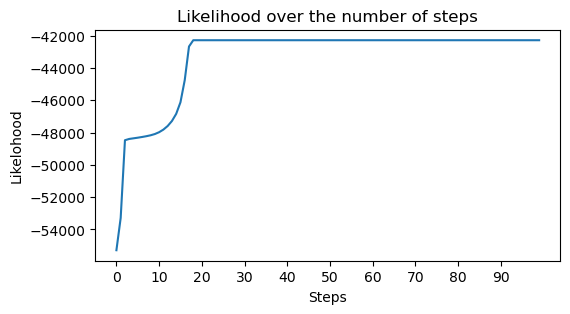

In [150]:
G = EM_GMM(X, n_clusters = 3)
G.fit(max_iter = 100, verbose=True)
mu_pred, sigma_pred, alpha_pred, likelihoods_pred = G.best_mu, G.best_sigma, G.best_alpha, G.evolution_likelihood
print("Predicted means:", mu_pred)  
print("Predicted standard deviations:", sigma_pred)
plt.figure(figsize=(6,3))
plt.plot(range(len(likelihoods_pred)), likelihoods_pred)
plt.title('Likelihood over the number of steps')
plt.xlabel('Steps')
plt.ylabel('Likelohood')
plt.xticks(np.arange(0, len(likelihoods_pred), 10))
plt.show()

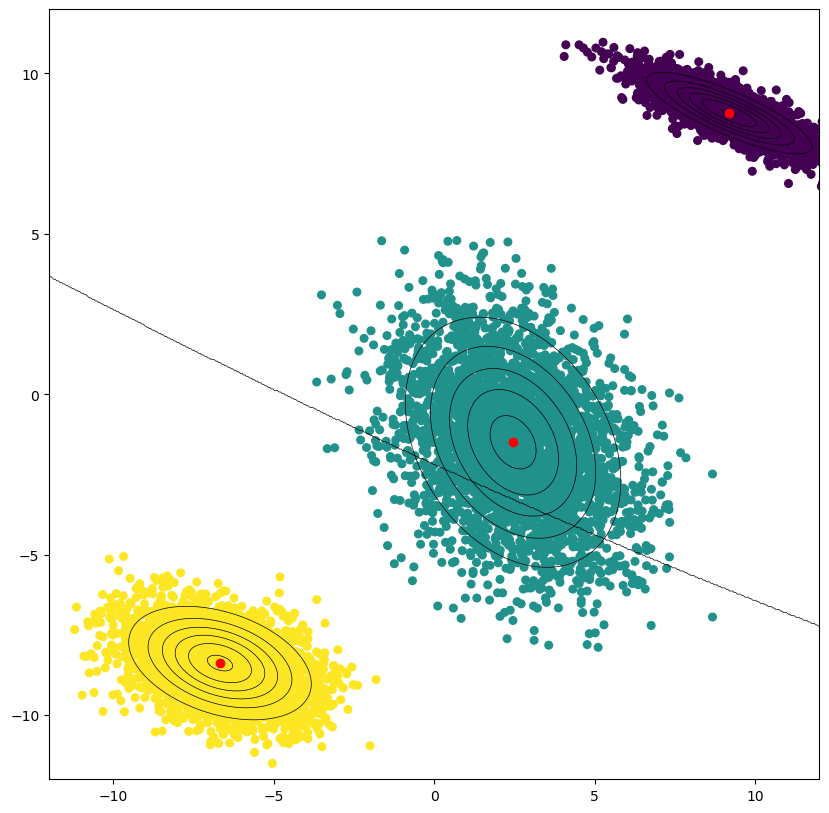

In [151]:
G.plot_clusters()

## Question 4: Are the estimated parameters far from the original ones ?

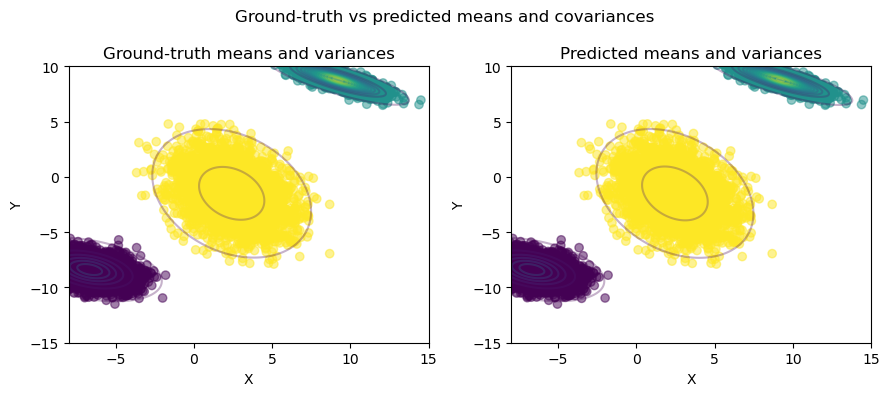

In [152]:
def plot_results(X, z, mu, sigma, ax, title, xlabel='X', ylabel='Y', levels=15, min_level=1e-3, max_level=0.3, alpha_scatter=0.5, alpha_ellipse=0.3, xlim=None, ylim=None):
    x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 1000), 
                   np.linspace(X[:, 1].min(), X[:, 1].max(), 1000))
    pos = np.dstack((x, y))
    levels = np.linspace(min_level, max_level, levels)
    
    ax.set_title(title)
    ax.scatter(X[:,0], X[:,1], c=z, alpha=alpha_scatter)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        ax.set_ylim(bottom=ylim[0], top=ylim[1])
    for m, s in zip(mu, sigma):
        rv = stats.multivariate_normal(m, s)
        ax.contour(x, y, rv.pdf(pos), levels=levels, alpha=alpha_ellipse)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle(f'Ground-truth vs predicted means and covariances')
plot_results(
            X, 
            z, 
            mu, 
            sigma, 
            ax1, 
            'Ground-truth means and variances',
            xlim=(-8,15),
            ylim=(-15,10)
)

plot_results(
            X, 
            z, 
            mu_pred, 
            sigma_pred, 
            ax2, 
            'Predicted means and variances',
            xlim=(-8,15),
            ylim=(-15,10)
)
plt.tight_layout()
plt.show()